# Day 1: IDE, basic data types, operators
# Day 2: Slicing, NumPy <code>array</code>
# Day 3: Pandas <code>DataFrame</code>
# Day 4: Case Study: Microarray Data analysis and Visualization

* file: <code>ExampleMicroarrayData.xls</code>
* Data: brain region microarray data (measures gene expression levels in a tissue)
* Experimental variables = tissue type
    * hippocampus & cerebral cortex
* Columns: 4 repeats for each tissue type
* Rows: 1 row per read; 1 or more rows per gene. Redundant reads need to be merged.

## Analysis Method

1. Import file
2. For a given gene with redundant reads, take maximum value (collapse multiple rows into one row)
3. Log transform
4. Z-score
5. For each comparison, take difference of means of repeats and p-value
6. Create ribbon plot for genes with fold change of 1 and p-value < 0.05

## Import libraries

In [1]:
import pandas as pd
import numpy as np

## Optional: set Pandas display precision

Use <code>TAB</code> key to show you what options are available

In [2]:
pd.options.display

In [3]:
pd.options.display.precision = 3

## Read in Excel File

In [4]:
microa = pd.read_excel( 'ExampleMicroarrayData.xls')

## See what we got

In [ ]:
microa.head()

In [5]:
microa.shape

(59734, 10)

In [6]:
microa.columns

Index(['ArrayID', 'Symbol', 'BR1_1', 'BR1_2', 'BR1_3', 'BR1_4', 'BR2_1',
       'BR2_2', 'BR2_3', 'BR2_4'],
      dtype='object')

## Review: Get basic statistics across all columns using <code>.describe()</code>

In [ ]:
microa.describe()

## Review: subselect rows by boolean criterion using brackets <code>[]</code>

In [ ]:
microa[ microa.Symbol == 'Mfsd9' ]

## Review: subselect one or more columns using brackets <code>[]</code>

In [ ]:
microa[ 'Symbol' ]

In [ ]:
microa[ ['ArrayID', 'Symbol' ] ]

## For subselecting rows and columns at the same time, use <code>.loc[]</code> (or<code>.iloc[]</code>)

In [ ]:
microa.loc[ microa.Symbol == 'Mfsd9', ['BR1_1', 'BR2_1' ] ]

## Note: Difference between <code>.loc[]</code> and <code>.iloc[]</code>

* Use <code>.loc[]</code> to slice by row/column *NAMES* or *BOOLEANS*
* Use <code>.iloc[]</code> to slice by row/column *INDICES* (Like we used with NumPy)

In [ ]:
microa.loc[ :10, -4: ]

In [ ]:
microa.iloc[ :10, -4: ]

## How many unique gene symbols do we have?

In [7]:
len( microa.Symbol )

59734

In [8]:
microa.Symbol.unique()

array(['NA1', 'NA2', 'NA3', ..., 'NA11372', 'NA11373', 'NA11374'], dtype=object)

In [9]:
len(microa.Symbol.unique())

29784

In [ ]:
microa.Symbol.value_counts()

## Group rows by gene symbol using <code>.groupby()</code>

* Pass the function the name of the column containing the values you want to group by

In [10]:
grouped = microa.groupby('Symbol')

### Get a certain group using <code>.get_group()</code>

In [ ]:
grouped.get_group( 'Mfsd9' )

In [ ]:
grouped.agg( 'max')

## Combine reads

Take maximum expression level for a given gene.

In [12]:
max_expression = grouped.max()

In [13]:
max_expression.shape

(29784, 9)

In [ ]:
max_expression

## <code>.apply()</code> a log transformation function over all expression values

In [ ]:
np.log?

In [14]:
np.log( [1, 10, 100, 1000] )

array([ 0.        ,  2.30258509,  4.60517019,  6.90775528])

In [15]:
log_trans = max_expression.apply( np.log )

In [ ]:
log_trans

## <code>.apply()</code> a Z-score transformation function over all genes

In [16]:
from scipy.stats import zscore

In [17]:
zscore( [ 1,2,3,4,5,6,7,8,9,10] )

array([-1.5666989 , -1.21854359, -0.87038828, -0.52223297, -0.17407766,
        0.17407766,  0.52223297,  0.87038828,  1.21854359,  1.5666989 ])

In [18]:
z_trans = log_trans.apply(zscore)

In [ ]:
log_trans.apply?

In [19]:
z_trans.shape

(29784, 9)

In [ ]:
z_trans

## Compare: Make a histogram of fold change

In [20]:
br1 = z_trans[ ['BR1_1','BR1_2', 'BR1_3', 'BR1_4' ] ]

In [21]:
br1.shape

(29784, 4)

In [22]:
br2 = z_trans[ ['BR2_1','BR2_2', 'BR2_3', 'BR2_4' ] ]

In [23]:
br2.shape

(29784, 4)

In [24]:
br1_mean = br1.mean(axis=1)
br2_mean = br2.mean(axis=1)

In [25]:
br2_mean.shape

(29784,)

In [26]:
diff = br2_mean - br1_mean

In [27]:
diff.shape

(29784,)

In [28]:
# tell Jupyter Notebook to show the figure after it made it
%matplotlib inline

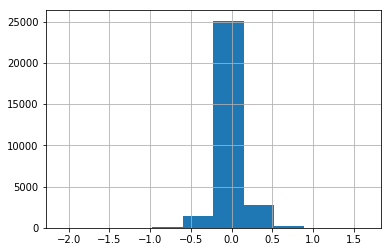

In [29]:
diff.hist()

## Subselect genes based on having fold change > 1

In [ ]:
diff[ diff.abs() > 1 ]

## Get gene expression difference and p-value for desired comparisons

Use Wilcoxon rank-sum statistic for two samples to test if the reads for a given gene across comparison groups come from different distributions.

In [30]:
from scipy.stats import ranksums

In [31]:
ranksums( [1,2,3,4], [5,6,7,8])

RanksumsResult(statistic=-2.3094010767585034, pvalue=0.020921335337794014)

In [32]:
ranksums( [1,2,3,4], [50,60,70,80])

RanksumsResult(statistic=-2.3094010767585034, pvalue=0.020921335337794014)

In [33]:
ranksums( [1,2,3,5], [4,6,7,8])

RanksumsResult(statistic=-2.0207259421636903, pvalue=0.043308142810791955)

### Go row-by-row doing significance test

In [34]:
import time

In [35]:
# create an empty list onto which we can append p-values
pval_list = []

In [36]:
t1 = time.time()

# iterate over every gene
for gene in br1.index:
    
    # subselect the expression values for the corresponding gene
    vals1 = br1.loc[ gene ]
    vals2 = br2.loc[ gene ]
    
    # Do the statistical test for this gene
    statistic, pvalue = ranksums( vals1, vals2 )
    
    # save the p-value
    pval_list.append( pvalue )

t2 = time.time()
print( "This operation took", t2-t1, "seconds.")

This operation took 11.919003009796143 seconds.


In [37]:
len(pval_list)

29784

In [38]:
# One-liner!
t1 = time.time()
pval_list = [ ranksums(a,b)[1] for a, b in zip( br1.as_matrix(), br2.as_matrix() ) ]
t2 = time.time()
print( "This operation took", t2-t1, "seconds.")

This operation took 4.959620952606201 seconds.


## Combine fold change and p-value into one DataFrame

* Problem 1: the diff object is just one column (a Pandas "<code>Series</code>" object), not a full-fledged <code>DataFrame</code>
* Problem 2: the p-values are stored in a simple Python <code>list</code>
* Solution: use the <code>to_frame()</code> function to turn the <code>Series</code> into a <code>DataFrame</code>, then add the p-values as a new column to that <code>DataFrame</code>.

In [39]:
type( diff )

pandas.core.series.Series

In [ ]:
diff.head()

In [40]:
combined = diff.to_frame()

In [ ]:
combined.head()

In [41]:
combined = diff.to_frame( name='fold')

In [ ]:
combined.head()

In [42]:
combined[ 'pvals' ] = pval_list

In [ ]:
combined.head()

In [43]:
combined.shape

(29784, 2)

## Subselect genes with fold change > 1

In [ ]:
combined[ combined.fold.abs() > 1 ]

## Subselect genes with fold change > 1 AND p-value < 0.05

In [ ]:
combined[ (combined.fold.abs() > 1) & (combined.pvals < 0.05) ]

In [44]:
plot_these = combined[ (combined.fold.abs() > 1) & (combined.pvals < 0.05) ]

In [45]:
len(plot_these)

36

Turn the row labels into variables in their own right:

In [46]:
plot_these['Gene'] = plot_these.index

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [47]:
plot_these.sort_values(by='fold', inplace=True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Generate RibbonPlot

### Load some of Python's figure-making libraries:

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

### Set the style of the figure

When using the plotting package seaborn, there are five figure [styles](https://seaborn.pydata.org/tutorial/aesthetics.html) to choose from:
1. darkgrid
2. whitegrid
3. dark
4. white
5. ticks

In [49]:
sns.set( style="whitegrid" )

### Making the figure 

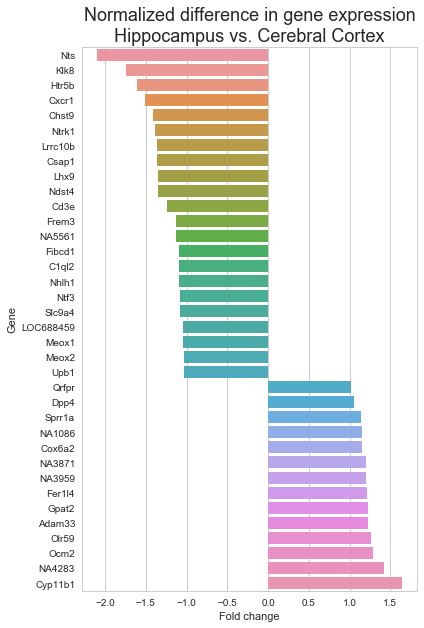

In [50]:
# I want this figure to be 6 inches wide and 10 inches tall
fig_dimensions=(6, 10)

# Create a blank figure to hang the data off of
figure, axes = plt.subplots( figsize=fig_dimensions )

# Plot the data onto the figure
sns.barplot( data=plot_these, x="fold", y="Gene" )

# Assign a title to the figure
chart_title = """Normalized difference in gene expression
Hippocampus vs. Cerebral Cortex"""
axes.set_title( chart_title, size=18 )

# Assign a label to the x-axis
axes.set_xlabel( "Fold change" )

### Save the figure as a PDF:

In [ ]:
figure.savefig( "ribbonplot.pdf")